# Applied Data Science Capstone Project W3 Part 3: Cluster the neighborhoods in Toronto

For this assignment, you will be required to explore and cluster the neighborhoods in Toronto.

<ol>
    <li>Start by creating a new Notebook for this assignment.</li>
    <li>Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe </li>
</ol>


## Create the dataframe

<ul>
    <li>The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood</li>
    <li>Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned</li>
    <li>More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.</li>
    <li>If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.</li>
    <li>Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.</li>
    <li>In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.</li>
</ul>

In [1]:
import pandas as pd

In [2]:
url_wp_toronto ='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

print("Downloading Data: " + url_wp_toronto)
tables = pd.read_html(url_wp_toronto) # Returns list of all tables on page
toronto_neighborhoods = tables[0]

print("{} records found".format(toronto_neighborhoods.shape[0]))
      
toronto_neighborhoods.head()

288 records found


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [3]:
# Check boroughs
toronto_neighborhoods.groupby('Borough').count()

,Postcode,Neighbourhood
Borough,,
Central Toronto,17,17
Downtown Toronto,37,37
East Toronto,7,7
East York,6,6
Etobicoke,45,45
Mississauga,1,1
North York,38,38
Not assigned,77,77
Queen's Park,1,1


### Step 1: Data Cleaning #1
Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned

In [4]:
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods['Borough'] != 'Not assigned'].reset_index()

### Step 2: Data Cleaning #2
If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.  So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.

In [5]:
toronto_neighborhoods.loc[toronto_neighborhoods['Neighbourhood'] == 'Not assigned', 'Neighbourhood'] = toronto_neighborhoods['Borough']

### Step 3: Data Shaping
More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined in to one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

In [6]:
toronto_agg_neighborhoods = toronto_neighborhoods.groupby(['Postcode','Borough'],as_index=False)['Neighbourhood'].agg(','.join)

In [7]:
print('Cleaning complete!')

Cleaning complete!


In [8]:
print("{} records remaining after data cleaning and shaping".format(toronto_agg_neighborhoods.shape[0]))
toronto_agg_neighborhoods.head()

103 records remaining after data cleaning and shaping


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Step 4: Add geographical coordinates
Read the geographical coordinates of each postal code from http://cocl.us/Geospatial_data and merge them in toronto_agg_neighborhoods

In [9]:
url_zip_pos = 'https://cocl.us/Geospatial_data'

toronto_zip_pos = pd.read_csv(url_zip_pos)

In [10]:
toronto_zip_pos.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
toronto_agg_neighborhoods = toronto_agg_neighborhoods.join(toronto_zip_pos.set_index('Postal Code'), on='Postcode')

toronto_agg_neighborhoods.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Step 5: Find venues in the neighborhoods in Toronto

Extract only boroughs that contain the word Toronto  

In [12]:
toronto_nb = toronto_agg_neighborhoods[toronto_agg_neighborhoods['Borough'].str.lower().str.contains('toronto')>0].reset_index(drop=True)
toronto_nb.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# uncomment the following line to install folium
# !conda install -c conda-forge folium=0.5.0 --yes
import folium
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np 
import requests 

# uncomment the following line to install geopy
# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


Define Fortsquare credentials constant for later use

In [14]:
CLIENT_ID = '********' # overridden
CLIENT_SECRET = '********' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Define function to retrieve the venues within a Neighbourhood

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, results_limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("Processing {}...".format(name))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            results_limit)
         
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Identify all the venues within the neighborhoods

In [16]:
toronto_venues = getNearbyVenues(names=toronto_nb['Neighbourhood'],
                                   latitudes=toronto_nb['Latitude'],
                                   longitudes=toronto_nb['Longitude']
                                  )

print('{} venues were found in Toronto using Foursquare.'.format(toronto_venues.shape))
toronto_venues.head()

Processing The Beaches...
Processing The Danforth West,Riverdale...
Processing The Beaches West,India Bazaar...
Processing Studio District...
Processing Lawrence Park...
Processing Davisville North...
Processing North Toronto West...
Processing Davisville...
Processing Moore Park,Summerhill East...
Processing Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West...
Processing Rosedale...
Processing Cabbagetown,St. James Town...
Processing Church and Wellesley...
Processing Harbourfront,Regent Park...
Processing Ryerson,Garden District...
Processing St. James Town...
Processing Berczy Park...
Processing Central Bay Street...
Processing Adelaide,King,Richmond...
Processing Harbourfront East,Toronto Islands,Union Station...
Processing Design Exchange,Toronto Dominion Centre...
Processing Commerce Court,Victoria Hotel...
Processing Roselawn...
Processing Forest Hill North,Forest Hill West...
Processing The Annex,North Midtown,Yorkville...
Processing Harbord,University of Toronto...

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West,Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


Check how many venues have been identified for each neighborhood

In [17]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Berczy Park,57,57,57,57,57,57
"Brockton,Exhibition Place,Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,19,19,19,19,19,19
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",17,17,17,17,17,17
"Cabbagetown,St. James Town",46,46,46,46,46,46
Central Bay Street,85,85,85,85,85,85
"Chinatown,Grange Park,Kensington Market",100,100,100,100,100,100
Christie,16,16,16,16,16,16


In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 237 uniques categories.


### Step 6: Analyze the neighborhoods

In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.head()

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 
toronto_onehot.head()

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Extract the frequency of the venue categories in all the neighborhoods

In [20]:
toronto_nb_freq = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_nb_freq

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide,King,Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.00,0.010000,0.010000,0.000000,0.020000,0.000000,0.000000,0.000000,0.0000,0.000000,0.020000,0.000000,0.040000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.020000,0.000000,0.000000,0.01,0.030000,0.010000,0.00,0.000000,0.050000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.080000,0.000000,0.000000,0.00,0.01,0.000000,0.000000,0.020000,0.000000,0.030000,0.000000,0

Identify the 10 most common venues within the neighborhood

In [21]:
# a function that selects the 10 most frequent venues
def get_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

TOP_VENUES_LIMIT = 10

ORDINAL_INDICATORS = ('st', 'nd', 'rd')

# create columns according to number of top venues
columns = ['Neighbourhood']
for i in range(TOP_VENUES_LIMIT):
    if i < len(ORDINAL_INDICATORS):
        columns.append('{}{} Most Common Venue'.format(i+1, ORDINAL_INDICATORS[i]))
    else:
        columns.append('{}th Most Common Venue'.format(i+1))

# create a new sorted dataframe
nb_venues_sorted = pd.DataFrame(columns=columns)
nb_venues_sorted['Neighbourhood'] = toronto_nb_freq['Neighbourhood']

for ind in np.arange(toronto_nb_freq.shape[0]):
    nb_venues_sorted.iloc[ind, 1:] = get_most_common_venues(toronto_nb_freq.iloc[ind, :], TOP_VENUES_LIMIT)

nb_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Steakhouse,Bar,Hotel,Burger Joint,American Restaurant,Thai Restaurant,Restaurant,Cosmetics Shop
1,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Cheese Shop,Café,Farmers Market,Italian Restaurant,Beer Bar,Bakery,Seafood Restaurant
2,"Brockton,Exhibition Place,Parkdale Village",Coffee Shop,Café,Breakfast Spot,Performing Arts Venue,Gym,Intersection,Pet Store,Climbing Gym,Caribbean Restaurant,Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Recording Studio
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Bar,Plane,Coffee Shop,Sculpture Garden,Boutique,Boat or Ferry


### Step 7: Cluster Data

In [22]:
toronto_nb_features = toronto_nb_freq.drop('Neighbourhood', 1)

The Elbow method is used to identify the optimal k for the Kmeans clusering

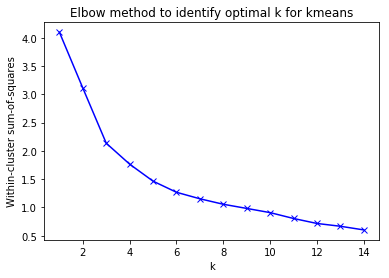

In [23]:
%matplotlib inline

inertia = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0).fit(toronto_nb_features)
    inertia.append(kmeans.inertia_)
    
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum-of-squares')
plt.title('Elbow method to identify optimal k for kmeans')
plt.show()

Using the <b>elbow method</b>, the <b>optimal k is 5</b>.

In [24]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_nb_features)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [25]:
# add clustering labels
nb_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_clustered = toronto_nb

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_clustered = toronto_clustered.join(nb_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_clustered.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Neighborhood,Trail,Pub,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,2,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Pizza Place,Brewery,Bubble Tea Shop,Restaurant
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,2,Sushi Restaurant,Sandwich Place,Italian Restaurant,Intersection,Brewery,Movie Theater,Ice Cream Shop,Pub,Burrito Place,Fish & Chips Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Cheese Shop,Fish Market,Bookstore,Seafood Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Photography Studio,Park,Bus Line,Swim School,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


Plot results on a map 

In [26]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="py_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], width=750, height=500, zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_clustered['Latitude'], toronto_clustered['Longitude'], toronto_clustered['Neighbourhood'], toronto_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Toronto, Canada are 43.653963, -79.387207.


### Step 8: Examine clusters

In [27]:
toronto_clustered.loc[toronto_clustered['Cluster Labels'] == 0, toronto_clustered.columns[[1] + list(range(5, toronto_clustered.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,0,Health Food Store,Neighborhood,Trail,Pub,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


In [28]:
toronto_clustered.loc[toronto_clustered['Cluster Labels'] == 1, toronto_clustered.columns[[1] + list(range(5, toronto_clustered.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,1,Photography Studio,Park,Bus Line,Swim School,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
10,Downtown Toronto,1,Park,Playground,Trail,Building,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
23,Central Toronto,1,Sushi Restaurant,Jewelry Store,Park,Trail,Yoga Studio,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Electronics Store


In [29]:
toronto_clustered.loc[toronto_clustered['Cluster Labels'] == 2, toronto_clustered.columns[[1] + list(range(5, toronto_clustered.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,East Toronto,2,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Pizza Place,Brewery,Bubble Tea Shop,Restaurant
2,East Toronto,2,Sushi Restaurant,Sandwich Place,Italian Restaurant,Intersection,Brewery,Movie Theater,Ice Cream Shop,Pub,Burrito Place,Fish & Chips Shop
3,East Toronto,2,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Cheese Shop,Fish Market,Bookstore,Seafood Restaurant
5,Central Toronto,2,Hotel,Dance Studio,Gym / Fitness Center,Gym,Sandwich Place,Breakfast Spot,Park,Clothing Store,Food & Drink Shop,Yoga Studio
6,Central Toronto,2,Coffee Shop,Sporting Goods Shop,Clothing Store,Gift Shop,Furniture / Home Store,Mexican Restaurant,Diner,Dessert Shop,Park,Chinese Restaurant
7,Central Toronto,2,Dessert Shop,Sandwich Place,Italian Restaurant,Café,Pizza Place,Coffee Shop,Gym,Sushi Restaurant,Japanese Restaurant,Flower Shop
9,Central Toronto,2,Pub,Coffee Shop,Pizza Place,Light Rail Station,Sports Bar,Restaurant,Bagel Shop,Supermarket,Sushi Restaurant,Fried Chicken Joint
11,Downtown Toronto,2,Coffee Shop,Bakery,Park,Flower Shop,Italian Restaurant,Pizza Place,Pub,Chinese Restaurant,Convenience Store,Restaurant
12,Downtown Toronto,2,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Hotel,Gym,Bubble Tea Shop,Burger Joint,Café
13,Downtown Toronto,2,Coffee Shop,Café,Pub,Bakery,Park,Restaurant,Gym / Fitness Center,Theater,Mexican Restaurant,Breakfast Spot


In [30]:
toronto_clustered.loc[toronto_clustered['Cluster Labels'] == 3, toronto_clustered.columns[[1] + list(range(5, toronto_clustered.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,3,Garden,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [31]:
toronto_clustered.loc[toronto_clustered['Cluster Labels'] == 4, toronto_clustered.columns[[1] + list(range(5, toronto_clustered.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,4,Playground,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
